## Soybean Yield (BU/Acre) Modeling 

### Rahul Zalkikar | rz1567@nyu.edu

A Quantitative Approach

#### Cell Hide Function

In [796]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

#### Imports

In [826]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import metrics, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor
from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

#### Import our Data

Our merged dataset contains yearly state feature data representing soil condition, weather and moisture, and geospatial data related to the planting and harvesting of soybean, along with the yield (our target variable) and production value metrics.

This data was primarly compiled through the USDA (soybean related data) and NOAA (climate and weather related data) via API and manual download.

Values of -99.0 represent an instance of no data, and NaN values represent an NA data value.

In [798]:
proj_dir = os.getcwd()+'\\OneDrive\\Pictures\\Documents\\DS-GA1001-Repo\\Veggie-Tales\\final_repo\\' # connact to our repo
merged_df = pd.read_csv(proj_dir+'dat\\Processed_Outputs_NA_UPDATE2\\SOIL_DATA_MERGED.csv') # load our data
hide_toggle()

In [799]:
merged_df.head()

YEAR  LOCATION  STATE_ANSI  AREA_OPERATED_IN_ACRES  \
0  1996   ALABAMA           1               9700000.0   
1  1996  ARKANSAS           5              14900000.0   
2  1996  DELAWARE          10                590000.0   
3  1996   FLORIDA          12              10700000.0   
4  1996   GEORGIA          13              11400000.0   

   AREA_OPERATED_IN_ACRES_/_OPERATION  OPERATIONS_IN_OPERATIONS  \
0                                 198                     49000   
1                                 301                     49500   
2                                 211                      2800   
3                                 238                     45000   
4                                 233                     49000   

   AREA_HARVESTED_IN_ACRES  AREA_PLANTED_IN_ACRES  PRODUCTION_IN_BU  \
0                 305000.0               320000.0        10370000.0   
1                3600000.0              3650000.0       109800000.0   
2                 217000.0               220000.0         7595000.0   
3                  45000.0                47000.0         1125000.0   
4                 380000.0               400000.0         7980000.0   

   YIELD_IN_BU_/_ACRE  PRODUCTION_IN_$  PRICE_RECEIVED_IN_$_/_BU  \
0                34.0       76738000.0                      7.40   
1                30.5      755424000.0                      7.36   
2                35.0       54684000.0                      7.20   
3                25.0        7875000.0                      7.00   
4                21.0       53306000.0                      6.87   

   CONDITION_IN_PCT_VERY_POOR  CONDITION_IN_PCT_GOOD  CONDITION_IN_PCT_FAIR  \
0                         1.0                   63.0                   22.0   
1                         3.0                   42.5                   28.5   
2                       -99.0                  -99.0                  -99.0   
3                       -99.0                  -99.0                  -99.0   
4                         2.0                   49.0                   30.0   

   CONDITION_IN_PCT_POOR  CONDITION_IN_PCT_EXCELLENT  \
0                    2.0                         9.5   
1                   12.0                        14.0   
2                  -99.0                       -99.0   
3                  -99.0                       -99.0   
4                    7.0                         6.5   

   CONDITION_5_YEAR_AVG_IN_PCT_EXCELLENT  CONDITION_5_YEAR_AVG_IN_PCT_GOOD  \
0                                    NaN                               NaN   
1                                    NaN                               NaN   
2                                  -99.0                             -99.0   
3                                  -99.0                             -99.0   
4                                    NaN                               NaN   

   CONDITION_5_YEAR_AVG_IN_PCT_POOR  CONDITION_5_YEAR_AVG_IN_PCT_VERY_POOR  \
0                               NaN                                    NaN   
1                               NaN                                    NaN   
2                             -99.0                                  -99.0   
3                             -99.0                                  -99.0   
4                               NaN                                    NaN   

   CONDITION_5_YEAR_AVG_IN_PCT_FAIR  CONDITION_PREVIOUS_YEAR_IN_PCT_POOR  \
0                               NaN                                  NaN   
1                               NaN                                  NaN   
2                             -99.0                                -99.0   
3                             -99.0                                -99.0   
4                               NaN                                  NaN   

   CONDITION_PREVIOUS_YEAR_IN_PCT_GOOD  \
0                                  NaN   
1                                  NaN   
2                                -99.0   
3                                -99.0   
4   

In [800]:
merged_df.shape

(722, 1281)


#### Data Processing

#### Data Processing

We have 1281 features and 722 data points.

First we have to group by state, sort by year, and then lag features measured after Yield in BU per Acre, features that wouldn't be known at the moment of soybean planting in a real-life predictive use case.

We will also leverage lagged Yield in BU per Acre as a feature.

Then we will fill NaN values with 0s as they likely represent no instances of a given feature, and -99.0 values with NaNs before linearly interpolating and extrpolating their values (across both directions).

Finally, we will drop feature columns that represent the same information on a different scale since our goal is to build a  real predictive model that can generalize well (ex. lagged yield and lagged production value, or state and area planted).

In [801]:
print("Number of NaN vals:",merged_df.isna().sum().sum())
merged_df = merged_df.fillna(0)
merged_df = merged_df.replace(-99.0,np.NaN)
print("Number of -99 vals:",merged_df.isna().sum().sum())

Number of NaN vals: 13715
Number of -99 vals: 4989


In [803]:
cols_to_lag = ['YIELD_IN_BU_/_ACRE','PRODUCTION_IN_BU','PRODUCTION_IN_$',
              'PRICE_RECEIVED_IN_$_/_BU','Crop Moisture Stress Index (CMSI)']

weather_cols = ['AVG_TEMP_Month','MAX_TEMP_Month','MIN_TEMP_Month','Precipitation_Month','PDSI_Month','PMDI_Month',
                'Z_index_Month','PHDI_Month']
counter = 0
for col in weather_cols:
    for i in range(4,13):
        cols_to_lag.append(col+str(i))
        
print("Number of columns to lag:",len(cols_to_lag))

Number of columns to lag: 77


In [804]:
final_df = pd.DataFrame()
for _,g in merged_df.groupby('LOCATION'):
    g.sort_values('YEAR',ascending=True)
    for col in cols_to_lag:
        g[col+'_lagged'] = g[col].shift(1)
        if col != 'YIELD_IN_BU_/_ACRE':
            del g[col]
    final_df = final_df.append(g)

C:\Users\rayzc\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [805]:
# Lagging a good number of features requires us to drop the year 1996 prior to linear interpolation/extrapolation. 
final_df = final_df[final_df.YEAR != 1996] 
# 2019 was almost entirely extrapolated so we remove it.
final_df = final_df[final_df.YEAR != 2019] 

In [806]:
#Interpolate/Extrapolate -99.0 values (which are now NaN values)
mis_cols = [col for col in final_df.columns if final_df[col].isna().any()]
for col in mis_cols:
    final_df[col] = final_df[col].interpolate(method='linear', axis=0, limit=None, 
                                              inplace=False, limit_direction='both', 
                                              limit_area=None, downcast=None)

In [807]:
# Drop features that include repetitive information
final_df = final_df.drop(['YIELD_IN_BU_/_ACRE_lagged','PRODUCTION_IN_BU_lagged',
                          'PRODUCTION_IN_$_lagged','PRICE_RECEIVED_IN_$_/_BU_lagged',
                          'STATE_ANSI','LOCATION','AREA_OPERATED_IN_ACRES',
                          'OPERATIONS_IN_OPERATIONS','AREA_HARVESTED_IN_ACRES',
                          'CONDITION_IN_PCT_EXCELLENT','CONDITION_IN_PCT_FAIR',
                          'CONDITION_IN_PCT_GOOD','CONDITION_IN_PCT_POOR',
                          'CONDITION_IN_PCT_VERY_POOR'],axis=1)

In [808]:
# Many columns are populated with 0s and therefore have 0 standard deviation. We want to drop these columns
for col in final_df.columns: 
    if final_df[col].std()==0:
        del final_df[col]

number of unique discrete yield vals: 86
number of yield data vals: 678


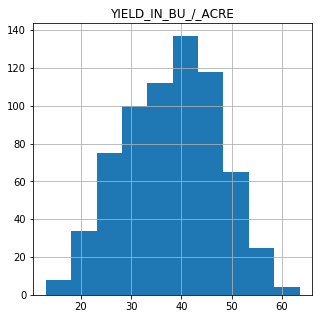

In [812]:
import matplotlib.pyplot as plt
%matplotlib inline
cols_to_hist = ['YIELD_IN_BU_/_ACRE'] # range from 12 - 63.5 
print("number of unique discrete yield vals:",len(list(set(final_df['YIELD_IN_BU_/_ACRE']))))
print("number of yield data vals:",len(list(final_df['YIELD_IN_BU_/_ACRE'])))
hist = final_df[cols_to_hist].hist(figsize=(5,5))
hist

hide_toggle()

To illustrate our model's ability to forecast the most recent year's yield per state, which is our intended use case, we now segment our final dataframe into a training and validation set (includes data from 1997 to 2017) and a testing set (includes 2018 data).

In [813]:
# there might be columns with all 0 values in our test / train set since we split by a year
test_df = final_df.loc[final_df.YEAR == 2018] 
train_val_df = final_df.loc[final_df.YEAR != 2018]

In [814]:
# we finally drop YEAR since our model should be time independent
final_df = final_df.drop(['YEAR'],axis=1)
test_df = test_df.drop(['YEAR'],axis=1)
train_val_df = train_val_df.drop(['YEAR'],axis=1)

In [815]:
# confirm shape consistency
print(test_df.shape, train_val_df.shape, final_df.shape)

(31, 792) (647, 792) (678, 792)


In [816]:
train_val_df.head()

,AREA_OPERATED_IN_ACRES_/_OPERATION,AREA_PLANTED_IN_ACRES,YIELD_IN_BU_/_ACRE,CONDITION_5_YEAR_AVG_IN_PCT_EXCELLENT,CONDITION_5_YEAR_AVG_IN_PCT_GOOD,CONDITION_5_YEAR_AVG_IN_PCT_POOR,CONDITION_5_YEAR_AVG_IN_PCT_VERY_POOR,CONDITION_5_YEAR_AVG_IN_PCT_FAIR,CONDITION_PREVIOUS_YEAR_IN_PCT_POOR,CONDITION_PREVIOUS_YEAR_IN_PCT_GOOD,CONDITION_PREVIOUS_YEAR_IN_PCT_VERY_POOR,CONDITION_PREVIOUS_YEAR_IN_PCT_EXCELLENT,CONDITION_PREVIOUS_YEAR_IN_PCT_FAIR,AVG_TEMP_Month1,AVG_TEMP_Month2,AVG_TEMP_Month3,MAX_TEMP_Month1,MAX_TEMP_Month2,MAX_TEMP_Month3,MIN_TEMP_Month1,MIN_TEMP_Month2,MIN_TEMP_Month3,Precipitation_Month1,Precipitation_Month2,Precipitation_Month3,PDSI_Month1,PDSI_Month2,PDSI_Month3,PMDI_Month1,PMDI_Month2,PMDI_Month3,Z_index_Month1,Z_index_Month2,Z_index_Month3,PHDI_Month1,PHDI_Month2,PHDI_Month3,NITROGEN,PHOSPHATE,POTASH,SULFUR,APPLICATIONS_IN_LB_FERTILIZER_NITROGEN,APPLICATIONS_IN_LB_FERTILIZER_PHOSPHATE,APPLICATIONS_IN_LB_FERTILIZER_POTASH,APPLICATIONS_IN_LB_FERTILIZER_SULFUR,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FERTILIZER_NITROGEN,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FERTILIZER_PHOSPHATE,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FERTILIZER_POTASH,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FERTILIZER_SULFUR,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FERTILIZER_NITROGEN,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FERTILIZER_PHOSPHATE,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FERTILIZER_POTASH,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FERTILIZER_SULFUR,APPLICATIONS_IN_NUMBER_AVG_FERTILIZER_NITROGEN,APPLICATIONS_IN_NUMBER_AVG_FERTILIZER_PHOSPHATE,APPLICATIONS_IN_NUMBER_AVG_FERTILIZER_POTASH,APPLICATIONS_IN_NUMBER_AVG_FERTILIZER_SULFUR,TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER_NITROGEN,TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER_PHOSPHATE,TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER_POTASH,TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER_SULFUR,AZOXYSTROBIN,PYRACLOSTROBIN,PROPICONAZOLE,TRIFLOXYSTROBIN,TEBUCONAZOLE,FLUXAPYROXAD,PROTHIOCONAZOLE,FLUAZINAM,TETRACONAZOLE,MYCLOBUTANIL,FLUOXASTROBIN,THIOPHANATE-METHYL,METCONAZOLE,CHLOROTHALONIL,DIFENOCONAZOLE,PICOXYSTROBIN,CYPROCONAZOLE,FLUOPYRAM,MONO-POTASSIUM SALT,BOSCALID,MEFENOXAM,BENZOVINDIFLUPYR,CONIOTHYRIUM MINITAN,BORAX DECAHYDRATE,ISOFETAMID,SEDAXANE,FLUDIOXONIL,FENHEXAMID,BACILLUS PUMILUS,MANCOZEB,ZOXAMIDE,STREPTOMYCES LYDICUS,CYPRODINIL,COPPER CHLORIDE HYD.,BASIC COPPER SULFATE,APPLICATIONS_IN_LB_FUNGICIDE_AZOXYSTROBIN,APPLICATIONS_IN_LB_FUNGICIDE_PYRACLOSTROBIN,APPLICATIONS_IN_LB_FUNGICIDE_PROPICONAZOLE,APPLICATIONS_IN_LB_FUNGICIDE_TRIFLOXYSTROBIN,APPLICATIONS_IN_LB_FUNGICIDE_TEBUCONAZOLE,APPLICATIONS_IN_LB_FUNGICIDE_FLUXAPYROXAD,APPLICATIONS_IN_LB_FUNGICIDE_PROTHIOCONAZOLE,APPLICATIONS_IN_LB_FUNGICIDE_TETRACONAZOLE,APPLICATIONS_IN_LB_FUNGICIDE_CHLOROTHALONIL,APPLICATIONS_IN_LB_FUNGICIDE_DIFENOCONAZOLE,APPLICATIONS_IN_LB_FUNGICIDE_PICOXYSTROBIN,APPLICATIONS_IN_LB_FUNGICIDE_CYPROCONAZOLE,APPLICATIONS_IN_LB_FUNGICIDE_BENZOVINDIFLUPYR,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_AZOXYSTROBIN,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_PYRACLOSTROBIN,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_PROPICONAZOLE,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_TRIFLOXYSTROBIN,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_TEBUCONAZOLE,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_FLUXAPYROXAD,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_PROTHIOCONAZOLE,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_TETRACONAZOLE,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_CHLOROTHALONIL,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_DIFENOCONAZOLE,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_PICOXYSTROBIN,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_CYPROCONAZOLE,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FUNGICIDE_BENZOVINDIFLUPYR,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FUNGICIDE_AZOXYSTROBIN,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FUNGICIDE_PYRACLOSTROBIN,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FUNGICIDE_PROPICONA

In [823]:
train_val_df.to_csv(os.getcwd()+'\\OneDrive\\Pictures\\Documents\\DS-GA1001-Repo\\Veggie-Tales\\rahul\\finaldatasets\\train.csv',index=False)
test_df.to_csv(os.getcwd()+'\\OneDrive\\Pictures\\Documents\\DS-GA1001-Repo\\Veggie-Tales\\rahul\\finaldatasets\\test.csv',index=False)
final_df.to_csv(os.getcwd()+'\\OneDrive\\Pictures\\Documents\\DS-GA1001-Repo\\Veggie-Tales\\rahul\\finaldatasets\\final_df.csv',index=False)
print("Data saved in repo")
hide_toggle()

Data saved in repo


In [822]:
# none of our features are highly correlated with yield besides yield itself
corr_df = pd.DataFrame(pd.DataFrame(train_val_df.corr())['YIELD_IN_BU_/_ACRE'].sort_values())
corr_df.reset_index(level=0, inplace=True)
high_cors = []
high_cors.append(corr_df['index'].loc[corr_df['YIELD_IN_BU_/_ACRE'] > 0.5])
high_cors.append(corr_df['index'].loc[corr_df['YIELD_IN_BU_/_ACRE'] < -0.5])
print("Corr > 0.5 with Yield:")
print(str(high_cors[0]))
print(str(high_cors[1]))
hide_toggle()

Corr > 0.5 with Yield:
742    YIELD_IN_BU_/_ACRE
Name: index, dtype: object
Series([], Name: index, dtype: object)


With a correlation matrix, you are examining unconditional (crude) associations between your variables. With any regression model, you are examining the joint associations of your IVs with your DVs, thus looking at conditional associations (for each IV, its association with the DV conditional on the other IVs). 

#### Feature Selection

We seperate the training/validation set (1997-2017 data) into a feature set and target set

In [824]:
target = ['YIELD_IN_BU_/_ACRE']
X = train_val_df.drop(target,axis=1)
y = train_val_df[target].values.reshape(-1)

We randomly split our feature and target sets into testing and training (20% test 80% train)

In [825]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [828]:
print("Train/Val Data Shape: ",train_val_df.shape) # all columns
print("Random Split Train/Valid Feature Data Shape: ",X_train.shape,X_test.shape) # don't have yield
print("Random Split Train/Valid Yield Data Shape: ",y_train.shape,y_test.shape) # only include yield

Train/Val Data Shape:  (647, 792)
Random Split Train/Valid Feature Data Shape:  (517, 791) (130, 791)
Random Split Train/Valid Yield Data Shape:  (517,) (130,)


In [829]:
def mean_absolute_percentage_error(y_test, y_pred): 
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [860]:
def reg_metrics(y_test,y_pred):
    print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred),2))  
    print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred),2))  
    print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),2))

In [859]:
def all_metrics(y_test,y_preds):
    print("r-squared:",round(r2_score(y_test,y_preds),2))
    print("MAPE:",round(mean_absolute_percentage_error(y_test,y_preds),2))
    reg_metrics(y_test,y_preds)

In [843]:
def plot_preds_exp(y_preds,y_true):
    plt.scatter(y_preds,y_true)
    min_plot = int(min(min(y_preds),min(y_true)))
    max_plot = int(max(max(y_preds),max(y_true)))
    plt.plot(range(min_plot,max_plot),range(min_plot,max_plot))
    plt.xlabel('predicted')
    plt.ylabel('truth')
    plt.show()

In [850]:
def feature_importance(X, clf,feat_import:bool):
    feats = {}
    if feat_import==False:
        for feature, importance in zip(X.columns, clf.coef_):
            feats[feature] = importance #add the name/value pair 
    else:
        for feature, importance in zip(X.columns, clf.feature_importances_):
            feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
    top_features = importances.sort_values(by='Importance')
    return top_features

Standardizing the features around the center and 0 with a standard deviation of 1 is important when we compare measurements that have different units. Variables that are measured at different scales do not contribute equally to the analysis and might end up creating a bais.

Lasso regression puts constraints on the size of the coefficients associated to each variable.
It is therefore necessary to center and reduce, or standardize, the variables.

In [832]:
std_fit = StandardScaler().fit(X_train)
X_train = std_fit.transform(X_train)
X_test = std_fit.transform(X_test)

C:\Users\rayzc\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\rayzc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\rayzc\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [833]:
# 2018 
X_2018 = test_df.drop(target,axis=1)
X_2018 = std_fit.transform(X_2018)
y_2018 = test_df[target].values.reshape(-1)

C:\Users\rayzc\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


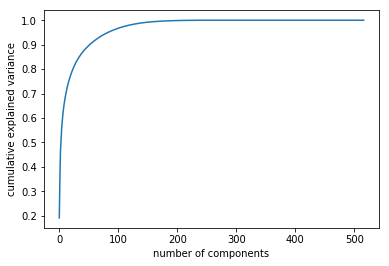

In [835]:
# feature variance chart 
pca = PCA(n_components=min(X_train.shape[0],X_train.shape[1]))
pca = pca.fit(normalize(X_train)) # have to normalize prior to any PCA
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
hide_toggle()

Now we are motivated to perform feature selection (Lasso, LassoCV, RF)

In [847]:
Lasso_model = linear_model.Lasso() #default
Lasso_model.fit(X_train,y_train)
train_preds_Lasso = Lasso_model.predict(X_train)
valid_preds_Lasso = Lasso_model.predict(X_test)
test_preds_Lasso = Lasso_model.predict(X_t)

Training:


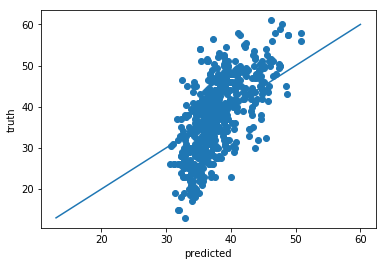

Validation:


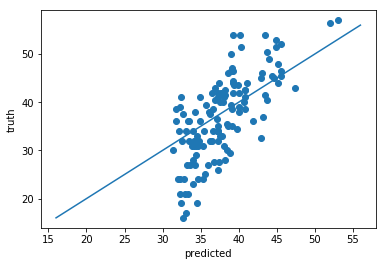

Testing (2018):


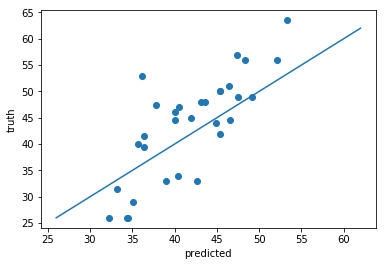

In [851]:
print("Training:")
plot_preds_exp(train_preds_Lasso,y_train)
print("Validation:")
plot_preds_exp(valid_preds_Lasso,y_test)
print("Testing (2018):")
plot_preds_exp(test_preds_Lasso,y_t)
hide_toggle()

In [852]:
Lasso_cols = feature_importance(X,Lasso_model,False)

In [854]:
print(Lasso_cols.head(5))
print(Lasso_cols.tail(5))
hide_toggle()

                                                    Importance
MAX_TEMP_Month8_lagged                               -1.521893
MAX_TEMP_Month1                                      -0.227428
MAX_TEMP_Month7_lagged                               -0.214781
TREATED_IN_PCT_OF_AREA_PLANTED_AVG_HERBICIDE_BE...   -0.175927
TREATED_IN_PCT_OF_AREA_PLANTED_AVG_HERBICIDE_AC...   -0.057954
                                                 Importance
Crop Moisture Stress Index (CMSI)_lagged           0.681689
Precipitation_Month12_lagged                       0.734187
CONDITION_5_YEAR_AVG_IN_PCT_EXCELLENT              0.778802
APPLICATIONS_IN_NUMBER_AVG_HERBICIDE_24-D 2-EHE    0.845278
AREA_PLANTED_IN_ACRES                              2.648752


Time for the lasso linear model with iterative fitting along a regularization path.
Since it provides sparse solutions, it is generally the model of choice (or some variant of this concept) for modelling cases for sparse data. In such a case, getting a sparse solution is of great computational advantage as the features with zero coefficients can simply be ignored.
The best model is selected by cross-validation.
The optimization objective for Lasso is:

$(1 / (2 * n_{samples})) * ||y - Xw||^2_2 + alpha * ||w||_1$

We will use SelectFromModel meta-transformer along with Lasso to select the best couple of features

In [855]:
# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
lassocv_clf = LassoCV(cv=5,tol=0.005,random_state=42)
# tolerance was so small that the optimization never reached a lower value.
#The tolerance for the optimization: if the updates are smaller than tol, the optimization code checks the dual gap for optimality and continues until it is smaller than tol.
sfm_lassocv = SelectFromModel(lassocv_clf)
sfm_lassocv.fit(X_train, y_train)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=42, selection='cyclic',
    tol=0.005, verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [856]:
print(sfm.transform(X_train).shape) # selected 82 columns

(517, 82)


In [857]:
estimator_coefs = sfm.estimator_.coef_
top_features_inds = estimator_coefs.argsort()[-82:][::-1]  # top 82 features
top_82_features_sorted = itemgetter(top_features_inds)(X.columns)
for item in top_82_features_sorted: print(item)
hide_toggle()

AREA_PLANTED_IN_ACRES
Crop Moisture Stress Index (CMSI)_lagged
CONDITION_5_YEAR_AVG_IN_PCT_EXCELLENT
Precipitation_Month12_lagged
APPLICATIONS_IN_NUMBER_AVG_HERBICIDE_24-D 2-EHE
Precipitation_Month5_lagged
CONDITION_5_YEAR_AVG_IN_PCT_GOOD
MIN_TEMP_Month12_lagged
TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FUNGICIDE_AZOXYSTROBIN
TREATED_IN_PCT_OF_AREA_PLANTED_AVG_HERBICIDE_24-D 2-EHE
CONDITION_PREVIOUS_YEAR_IN_PCT_VERY_POOR
TREATED_IN_PCT_OF_AREA_PLANTED_AVG_HERBICIDE_GLYPHOSATE ISO. SALT
Precipitation_Month8_lagged
APPLICATIONS_IN_LB_HERBICIDE_FLUFENACET
Precipitation_Month4_lagged
TREATED_IN_PCT_OF_AREA_PLANTED_AVG_HERBICIDE_IMAZETHAPYR
TREATED_IN_PCT_OF_AREA_PLANTED_AVG_HERBICIDE_GLYPHOSATE DIM. SALT
APPLICATIONS_IN_NUMBER_AVG_HERBICIDE_ALACHLOR
APPLICATIONS_IN_NUMBER_AVG_HERBICIDE_PYROXASULFONE
TREATED_IN_PCT_OF_AREA_PLANTED_AVG_HERBICIDE_FLUTHIACET-METHYL
TREATED_IN_PCT_OF_AREA_PLANTED_AVG_HERBICIDE_24-D DIMETH. SALT
TREATED_IN_PCT_OF_AREA_PLANTED_AVG_HERBICIDE_DICAMBA DIMET. SALT
TREATED_I

In [864]:
lassocv_clf.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=42, selection='cyclic',
    tol=0.005, verbose=False)

In [865]:
print("RAN ON ALL DATA")
print("Best alpha using built-in LassoCV: %f" %lassocv_clf.alpha_)
print("Best score using built-in LassoCV: %f" %lassocv_clf.score(X_train,y_train))
coef = pd.Series(lassocv_clf.coef_, index = X.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
train_preds_lassocv = lassocv_clf.predict(X_train)
valid_preds_lassocv = lassocv_clf.predict(X_test)
test_preds_lassocv = lassocv_clf.predict(X_t)
print("\nTraining:")
all_metrics(y_train,train_preds_lassocv)
print("\nValidation:")
all_metrics(y_test,valid_preds_lassocv)
print("\nTesting (2018):")
all_metrics(y_t,test_preds_lassocv)
hide_toggle()

RAN ON ALL DATA
Best alpha using built-in LassoCV: 0.184584
Best score using built-in LassoCV: 0.562066
Lasso picked 82 variables and eliminated the other 709 variables

Training:
r-squared: 0.56
MAPE: 14.34
Mean Absolute Error: 4.79
Mean Squared Error: 37.8
Root Mean Squared Error: 6.15

Validation:
r-squared: 0.51
MAPE: 15.05
Mean Absolute Error: 4.84
Mean Squared Error: 37.53
Root Mean Squared Error: 6.13

Testing (2018):
r-squared: 0.52
MAPE: 13.3
Mean Absolute Error: 5.19
Mean Squared Error: 44.33
Root Mean Squared Error: 6.66


Training:


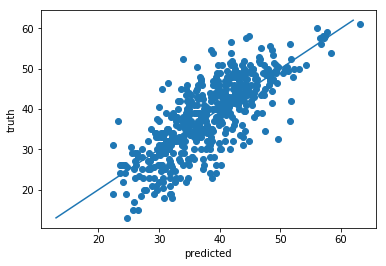

Validation:


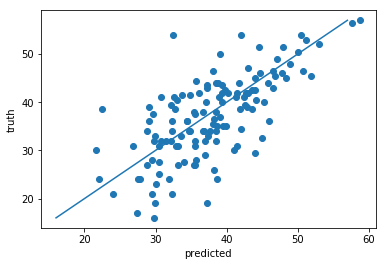

Testing (2018):


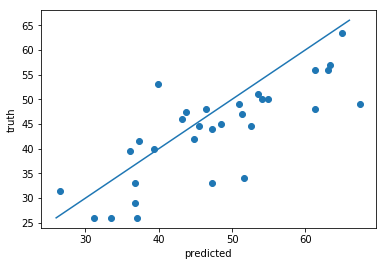

In [905]:
print("Training:")
plot_preds_exp(train_preds_lassocv,y_train)
print("Validation:")
plot_preds_exp(valid_preds_lassocv,y_test)
print("Testing (2018):")
plot_preds_exp(test_preds_lassocv,y_t)
hide_toggle()

In [866]:
# Our LASSOCV (82 features) selected data
X_train_transformed = sfm.transform(X_train)
X_valid_transformed = sfm.transform(X_test)
X_test_transformed = sfm.transform(X_t)
print(X_train_transformed.shape,X_test_transformed.shape,X_test_transformed.shape)

(517, 82) (31, 82) (31, 82)


In [883]:
lassocv_clf = LassoCV(cv=5,tol=0.005,random_state=42)
lassocv_clf.fit(X_train_transformed, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=42, selection='cyclic',
    tol=0.005, verbose=False)

In [884]:
print("RAN ON 82 FEATURES")
print("Best alpha using built-in LassoCV: %f" %lassocv_clf.alpha_)
print("Best score using built-in LassoCV: %f" %lassocv_clf.score(X_train_transformed,y_train))
coef = pd.Series(lassocv_clf.coef_, index = top_82_features_sorted)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
train_preds_lassocv = lassocv_clf.predict(X_train_transformed)
valid_preds_lassocv = lassocv_clf.predict(X_valid_transformed)
test_preds_lassocv = lassocv_clf.predict(X_test_transformed)
print("\nTraining:")
all_metrics(y_train,train_preds_lassocv)
print("\nValidation:")
all_metrics(y_test,valid_preds_lassocv)
print("\nTesting (2018):")
all_metrics(y_t,test_preds_lassocv)
hide_toggle()

RAN ON 82 FEATURES
Best alpha using built-in LassoCV: 0.039767
Best score using built-in LassoCV: 0.599978
Lasso picked 72 variables and eliminated the other 10 variables

Training:
r-squared: 0.6
MAPE: 13.52
Mean Absolute Error: 4.53
Mean Squared Error: 34.53
Root Mean Squared Error: 5.88

Validation:
r-squared: 0.46
MAPE: 15.44
Mean Absolute Error: 4.93
Mean Squared Error: 40.89
Root Mean Squared Error: 6.39

Testing (2018):
r-squared: 0.36
MAPE: 15.51
Mean Absolute Error: 6.12
Mean Squared Error: 59.63
Root Mean Squared Error: 7.72


In [885]:
rfr_clf = RandomForestRegressor(random_state=0)
rfr_clf.fit(X_train, y_train)

C:\Users\rayzc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [886]:
rfr_feats = feature_importance(X,rfr_clf,True)
rfr_feats.tail(15)

,Importance
CONDITION_PREVIOUS_YEAR_IN_PCT_POOR,0.010520
PHDI_Month11_lagged,0.011690
MIN_TEMP_Month10_lagged,0.012244
Precipitation_Month6_lagged,0.012629
Precipitation_Month1,0.016558
Crop Moisture Stress Index (CMSI)_lagged,0.017253
PMDI_Month3,0.018062
AVG_TEMP_Month1,0.022245
CONDITION_5_YEAR_AVG_IN_PCT_EXCELLENT,0.024643
MAX_TEMP_Month10_lagged,0.025589


In [880]:
print("DEFAULT RANDOM FOREST REGRESSOR - RAN ON ALL FEATURES")
print("Best score using built-in RF: %f" %rfr_clf.score(X_train,y_train))
train_preds_rfr = rfr_clf.predict(X_train)
valid_preds_rfr = rfr_clf.predict(X_test)
test_preds_rfr = rfr_clf.predict(X_t)
print("\nTraining:")
all_metrics(y_train,train_preds_rfr)
print("\nValidation:")
all_metrics(y_test,valid_preds_rfr)
print("\nTesting (2018):")
all_metrics(y_t,test_preds_rfr)
hide_toggle()

DEFAULT RANDOM FOREST REGRESSOR - RAN ON ALL FEATURES
Best score using built-in RF: 0.909814

Training:
r-squared: 0.91
MAPE: 5.85
Mean Absolute Error: 2.04
Mean Squared Error: 7.78
Root Mean Squared Error: 2.79

Validation:
r-squared: 0.5
MAPE: 14.9
Mean Absolute Error: 4.63
Mean Squared Error: 37.76
Root Mean Squared Error: 6.14

Testing (2018):
r-squared: 0.41
MAPE: 14.0
Mean Absolute Error: 6.09
Mean Squared Error: 55.06
Root Mean Squared Error: 7.42


In [888]:
rfr_clf = RandomForestRegressor(random_state=0)
rfr_clf.fit(X_train_transformed, y_train)

C:\Users\rayzc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [889]:
print("DEFAULT RANDOM FOREST REGRESSOR - RAN ON 82 FEATURES (from LassoCV)")
print("Best score using built-in RF: %f" %rfr_clf.score(X_train_transformed,y_train))
train_preds_rfr = rfr_clf.predict(X_train_transformed)
valid_preds_rfr = rfr_clf.predict(X_valid_transformed)
test_preds_rfr = rfr_clf.predict(X_test_transformed)
print("\nTraining:")
all_metrics(y_train,train_preds_rfr)
print("\nValidation:")
all_metrics(y_test,valid_preds_rfr)
print("\nTesting (2018):")
all_metrics(y_t,test_preds_rfr)
hide_toggle()

DEFAULT RANDOM FOREST REGRESSOR - RAN ON 82 FEATURES (from LassoCV)
Best score using built-in RF: 0.921279

Training:
r-squared: 0.92
MAPE: 5.63
Mean Absolute Error: 1.94
Mean Squared Error: 6.79
Root Mean Squared Error: 2.61

Validation:
r-squared: 0.53
MAPE: 15.14
Mean Absolute Error: 4.76
Mean Squared Error: 35.48
Root Mean Squared Error: 5.96

Testing (2018):
r-squared: 0.62
MAPE: 10.96
Mean Absolute Error: 4.79
Mean Squared Error: 35.35
Root Mean Squared Error: 5.95


In [893]:
# common top features from default random forest and default lasso cv
common_top_features = set(list(rfr_feats.tail(82).index)) & set(list(top_82_features_sorted))
list(common_top_features)

['CONDITION_5_YEAR_AVG_IN_PCT_GOOD',
 'Crop Moisture Stress Index (CMSI)_lagged',
 'Precipitation_Month8_lagged',
 'APPLICATIONS_IN_LB_HERBICIDE_GLYPHOSATE',
 'Precipitation_Month12_lagged',
 'Precipitation_Month5_lagged',
 'APPLICATIONS_IN_NUMBER_AVG_HERBICIDE_24-D 2-EHE',
 'MIN_TEMP_Month12_lagged',
 'Precipitation_Month3',
 'Precipitation_Month4_lagged',
 'AREA_PLANTED_IN_ACRES',
 'CONDITION_5_YEAR_AVG_IN_PCT_EXCELLENT']

In [897]:
X_train_common = X[list(common_top_features)]
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_train_common, y, test_size=0.2, random_state=42)
rfr_clf = RandomForestRegressor(random_state=0)
rfr_clf.fit(X_train_2, y_train_2)

C:\Users\rayzc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [898]:
print("DEFAULT RANDOM FOREST REGRESSOR - RAN ON COMMON TOP FEATURES (from LassoCV and RF)")
print("Best score using built-in RF: %f" %rfr_clf.score(X_train_2,y_train))
train_preds_rfr = rfr_clf.predict(X_train_2)
valid_preds_rfr = rfr_clf.predict(X_test_2)
print("\nTraining:")
all_metrics(y_train,train_preds_rfr)
print("\nValidation:")
all_metrics(y_test,valid_preds_rfr)

DEFAULT RANDOM FOREST REGRESSOR - RAN ON COMMON TOP FEATURES (from LassoCV and RF)
Best score using built-in RF: 0.916965

Training:
r-squared: 0.92
MAPE: 5.59
Mean Absolute Error: 1.96
Mean Squared Error: 7.17
Root Mean Squared Error: 2.68

Validation:
r-squared: 0.52
MAPE: 14.95
Mean Absolute Error: 4.76
Mean Squared Error: 36.55
Root Mean Squared Error: 6.05


Random forests select, at each candidate split in the decision tree learning process, a random subset of the features. Without feature bagging, if one or a few features are really strong predictors for yield per acre it is likely they will be present in many of the decision trees created, increasing the correlation between estimators and causing learners to be biased in favor of  features that appear highly predictive in the training set, but fail to be as predictive for unseen data points. 

Random forests are a way of averaging multiple deep decision trees, trained on different parts of the same training set, with the goal of reducing the variance with the cost of increased bias. 

Our first model is going to be a Random Forest Regressor via sklearn.

We leverage randomized search for optimizing our hyperparameters. All parameters that influence the learning are searched simultaneously (except for the number of estimators, which poses a time / quality tradeoff).

In [899]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [900]:
# A parameter grid for XGBoost
#Tune tree-specific parameters first
xgb_params = {
        'n_estimators': [int(x) for x in np.linspace(start = 1, stop = 100, num = 10)],
        'max_features': ['auto', 'sqrt'], # num features to consider at each split
        'min_child_weight': [1, 5, 10],
        '''
        Defines the minimum sum of weights of all observations required in a child.
        This is similar to min_child_leaf in GBM but not exactly. 
        This refers to min “sum of weights” of observations while GBM has min “number of observations”.
        Used to control over-fitting. 
        Higher values prevent a model from learning relations which might be highly specific 
        to the particular sample selected for a tree.
        Too high values can lead to under-fitting hence, it should be tuned using CV.
        '''
        'gamma': [0.5, 1, 1.5, 2, 5],
        '''
        A node is split only when the resulting split gives a positive reduction in the loss function. 
        Gamma specifies the minimum loss reduction required to make a split.
        Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
        '''
        'subsample': [0.6, 0.8, 1.0],
        ''' 
        Denotes the fraction of observations to be randomly samples for each tree.
        Lower values make the algorithm more conservative and prevents overfitting 
        but too small values might lead to under-fitting.
        '''
        'colsample_bytree': [0.6, 0.8, 1.0],
        '''
        Denotes the fraction of columns to be randomly samples for each tree.
        '''
        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)], # max num levels in tree
        '''
        Used to control over-fitting as higher depth will allow model to 
        learn relations very specific to a particular sample.
        '''
        'min_samples_split': [2, 5, 10], # min samples for a node split
        'min_samples_leaf': [1, 2, 4], # min samples at each leaf node
        'bootstrap': [True, False] # how to sample
        }
'''
xgb_reg_params = {
        'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
        #L1 regularization term on weights. 
        #Increasing this value will make model more conservative. Normalised to number of training examples.
        #'reg_lambda':[]
        }
'''
xgb_tune_params = {
        'learning_rate':[0.0025,0.005,0.0075,0.01,0.02]
        }
rfr_params = {
        'n_estimators': [int(x) for x in np.linspace(start = 1, stop = 100, num = 10)],
        'max_features': ['auto', 'sqrt'], # num features to consider at each split
        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)], # max num levels in tree
        'min_samples_split': [2, 5, 10], # min samples for a node split
        'min_samples_leaf': [1, 2, 4], # min samples at each leaf node
        'bootstrap': [True, False] # how to sample
        }

In [901]:
xgb = XGBRegressor(objective='reg:squarederror', #Linear regression uses (y - y_pred)^2 as the Cost Function
                    booster='gbtree',
                    silent=False, nthread=3) # 3 cores available

In [902]:
print(rfr)
print(xgb)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=3, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1, verbosity=1)


In [903]:
param_comb = 100 #how many different combinations should be picked randomly out of our total - this should be relatively high

In [904]:
random_search_rfr = RandomizedSearchCV(rfr, param_distributions=rfr_params, 
                                   n_iter=param_comb, scoring='neg_mean_squared_error', 
                                   n_jobs=4, cv=5, verbose=3, random_state=42)

random_search_xgb = RandomizedSearchCV(xgb, param_distributions=xgb_params, 
                                   n_iter=param_comb, scoring='neg_mean_squared_error', 
                                   n_jobs=4, cv=5, verbose=3, random_state=42)

Tuned Random Forest for all features and for subset of features

In [641]:
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search_rfr.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   51.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  4.0min finished
C:\Users\rayzc\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



 Time taken: 0 hours 4 minutes and 4.66 seconds.


In [642]:
random_search_rfr.best_params_

{'n_estimators': 56,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}

In [651]:
print("TUNED RF FOR ALL DATA -----\n")
rfr_train_preds_tuned_all = random_search_rfr.predict(X_train)
print("TRAINING:\n")
all_metrics(y_train,rfr_train_preds_tuned_all)

rfr_valid_preds_tuned_all = random_search_rfr.predict(X_test)
print("VALIDATION:\n")
all_metrics(y_test,rfr_valid_preds_tuned_all)

rfr_test_preds_tuned_all = random_search_rfr.predict(X_t)
print("\nTESTING:\n")
all_metrics(y_t,rfr_test_preds_tuned_all)

TUNED RF FOR ALL DATA -----

TRAINING:

r-squared: 0.9265198710189926
MAPE: 5.6472716657106
Mean Absolute Error: 1.9212887806637806
Mean Squared Error: 6.342021661094366
Root Mean Squared Error: 2.518337082499951
VALIDATION:

r-squared: 0.5642408550524762
MAPE: 14.29568259592012
Mean Absolute Error: 4.41724800497122
Mean Squared Error: 33.20317084828997
Root Mean Squared Error: 5.762219264162895

TESTING:

r-squared: 0.5363487014200655
MAPE: 12.376541310014789
Mean Absolute Error: 5.412296444115281
Mean Squared Error: 43.13259739130713
Root Mean Squared Error: 6.567541198295381


In [653]:
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search_rfr.fit(X_train_transformed, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 348 tasks      | elapsed:   34.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   52.6s finished
C:\Users\rayzc\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



 Time taken: 0 hours 0 minutes and 53.08 seconds.


In [654]:
random_search_rfr.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': False}

In [656]:
print("TUNED RF FOR SUBSET OF DATA -----\n")
rfr_train_preds_tuned_sub = random_search_rfr.predict(X_train_transformed)
print("TRAINING:\n")
all_metrics(y_train,rfr_train_preds_tuned_sub)

rfr_valid_preds_tuned_sub = random_search_rfr.predict(X_valid_transformed)
print("\nVALIDATION:\n")
all_metrics(y_test,rfr_valid_preds_tuned_sub)

rfr_test_preds_tuned_sub = random_search_rfr.predict(X_test_transformed)
print("\nTESTING:\n")
all_metrics(y_t,rfr_test_preds_tuned_sub)

TUNED RF FOR SUBSET OF DATA -----

TRAINING:

r-squared: 0.9832100748971713
MAPE: 2.623611227305366
Mean Absolute Error: 0.8825717651887254
Mean Squared Error: 1.4491274058298715
Root Mean Squared Error: 1.2037970783441334

VALIDATION:

r-squared: 0.5818233048518926
MAPE: 13.990664910511116
Mean Absolute Error: 4.303227360286172
Mean Squared Error: 31.863455798381366
Root Mean Squared Error: 5.644772431053476

TESTING:

r-squared: 0.7258789486189932
MAPE: 10.587857918076963
Mean Absolute Error: 4.236981442416746
Mean Squared Error: 25.500959410470355
Root Mean Squared Error: 5.0498474640795195


Tuned XGBooster for all features and subset of features

In [657]:
start_time = timer(None)
random_search_xgb.fit(X_train, y_train)
timer(start_time) 

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
C:\Users\rayzc\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  3.4min finished
C:\Users\rayzc\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



 Time taken: 0 hours 3 minutes and 23.58 seconds.


In [658]:
random_search_xgb.best_params_

{'n_estimators': 100,
 'min_samples_leaf': 1,
 'min_child_weight': 1,
 'max_features': 'auto',
 'bootstrap': False,
 ' \n        Denotes the fraction of observations to be randomly samples for each tree.\n        Lower values make the algorithm more conservative and prevents overfitting \n        but too small values might lead to under-fitting.\n        colsample_bytree': 1.0,
 '\n        Used to control over-fitting as higher depth will allow model to \n        learn relations very specific to a particular sample.\n        min_samples_split': 10,
 '\n        Denotes the fraction of columns to be randomly samples for each tree.\n        max_depth': 20,
 '\n        Defines the minimum sum of weights of all observations required in a child.\n        This is similar to min_child_leaf in GBM but not exactly. \n        This refers to min “sum of weights” of observations while GBM has min “number of observations”.\n        Used to control over-fitting. \n        Higher values prevent a mode

In [659]:
print("FIRST TUNING XGB FOR ALL DATA -----\n")
xgb_train_preds_first_all = random_search_xgb.predict(X_train)
print("TRAINING:\n")
all_metrics(y_train,xgb_train_preds_first_all)

xgb_valid_preds_first_all = random_search_xgb.predict(X_test)
print("VALIDATION:\n")
all_metrics(y_test,xgb_valid_preds_first_all)

xgb_test_preds_first_all = random_search_xgb.predict(X_t)
print("\nTESTING:\n")
all_metrics(y_t,xgb_test_preds_first_all)

FIRST TUNING XGB FOR ALL DATA -----

TRAINING:

r-squared: 0.9091614333076382
MAPE: 6.408702737850095
Mean Absolute Error: 2.1684856156546557
Mean Squared Error: 7.84021701669345
Root Mean Squared Error: 2.8000387527127995
VALIDATION:

r-squared: 0.6144248695396854
MAPE: 13.348756799144079
Mean Absolute Error: 4.105725405766414
Mean Squared Error: 29.37934195980496
Root Mean Squared Error: 5.420271391711393

TESTING:

r-squared: 0.7085593253330826
MAPE: 11.110672855032597
Mean Absolute Error: 4.569257551623929
Mean Squared Error: 27.11217098358212
Root Mean Squared Error: 5.206934893349649


In [687]:
# lower our learning rate for final tuning
xgb2 = XGBRegressor(objective='reg:squarederror', #Linear regression uses (y - y_pred)^2 as the Cost Function
                    booster='gbtree',
                   learning_rate = 0.075,
                    n_estimators =  100,
                    min_samples_leaf= 1,
                    min_child_weight=1,
                    max_features='auto',
                    colsample_bytree= 1.0,
                    min_samples_split= 10,
                    max_depth= 20,
                    gamma=5,
                    subsample=0.8,
                    bootstrap= False,
                    silent=False, nthread=3) # 3 cores available

In [688]:
start_time = timer(None)
xgb2.fit(X_train, y_train)
timer(start_time) 


 Time taken: 0 hours 0 minutes and 4.89 seconds.


In [689]:
print("SECOND TUNING XGB FOR ALL DATA -----\n")
xgb_train_preds_s_all = xgb2.predict(X_train)
print("TRAINING:\n")
all_metrics(y_train,xgb_train_preds_s_all)

xgb_valid_preds_s_all = xgb2.predict(X_test)
print("VALIDATION:\n")
all_metrics(y_test,xgb_valid_preds_s_all)

xgb_test_preds_s_all = xgb2.predict(X_t)
print("\nTESTING:\n")
all_metrics(y_t,xgb_test_preds_s_all)

SECOND TUNING XGB FOR ALL DATA -----

TRAINING:

r-squared: 0.9951454056879415
MAPE: 1.426451467318126
Mean Absolute Error: 0.5080441801414268
Mean Squared Error: 0.4189968459480832
Root Mean Squared Error: 0.6472996569967291
VALIDATION:

r-squared: 0.5945646995230653
MAPE: 13.43470730373336
Mean Absolute Error: 4.172188010582557
Mean Squared Error: 30.89261052980213
Root Mean Squared Error: 5.558112137210092

TESTING:

r-squared: 0.7138009589992533
MAPE: 10.579501963006068
Mean Absolute Error: 4.462288148941532
Mean Squared Error: 26.624551785085067
Root Mean Squared Error: 5.159898427787612


In [682]:
start_time = timer(None)
random_search_xgb.fit(X_train_transformed, y_train)
timer(start_time) 

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   15.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   26.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   42.3s finished
C:\Users\rayzc\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



 Time taken: 0 hours 0 minutes and 42.77 seconds.


In [684]:
random_search_xgb.best_params_

{'n_estimators': 100,
 'min_samples_leaf': 1,
 'min_child_weight': 1,
 'max_features': 'auto',
 'bootstrap': False,
 ' \n        Denotes the fraction of observations to be randomly samples for each tree.\n        Lower values make the algorithm more conservative and prevents overfitting \n        but too small values might lead to under-fitting.\n        colsample_bytree': 1.0,
 '\n        Used to control over-fitting as higher depth will allow model to \n        learn relations very specific to a particular sample.\n        min_samples_split': 10,
 '\n        Denotes the fraction of columns to be randomly samples for each tree.\n        max_depth': 20,
 '\n        Defines the minimum sum of weights of all observations required in a child.\n        This is similar to min_child_leaf in GBM but not exactly. \n        This refers to min “sum of weights” of observations while GBM has min “number of observations”.\n        Used to control over-fitting. \n        Higher values prevent a mode

In [685]:
print("FIRST TUNING XGB FOR SUBSET OF DATA -----\n")
xgb_train_preds_first_sub = random_search_xgb.predict(X_train_transformed)
print("TRAINING:\n")
all_metrics(y_train,xgb_train_preds_first_sub)

xgb_valid_preds_first_sub = random_search_xgb.predict(X_valid_transformed)
print("VALIDATION:\n")
all_metrics(y_test,xgb_valid_preds_first_sub)

xgb_test_preds_first_sub = random_search_xgb.predict(X_test_transformed)
print("\nTESTING:\n")
all_metrics(y_t,xgb_test_preds_first_sub)

FIRST TUNING XGB FOR SUBSET OF DATA -----

TRAINING:

r-squared: 0.8725902388646403
MAPE: 7.716478645888898
Mean Absolute Error: 2.6091625132459275
Mean Squared Error: 10.99665278437611
Root Mean Squared Error: 3.3161201402205123
VALIDATION:

r-squared: 0.6212389975660749
MAPE: 13.377527508673293
Mean Absolute Error: 4.147804773770845
Mean Squared Error: 28.860131612378805
Root Mean Squared Error: 5.372162656917491

TESTING:

r-squared: 0.7340795434970169
MAPE: 10.399536140714986
Mean Absolute Error: 4.260991065732894
Mean Squared Error: 24.738073685085013
Root Mean Squared Error: 4.973738401352147


In [690]:
# lower our learning rate for final tuning
xgb_sub2 = XGBRegressor(objective='reg:squarederror', #Linear regression uses (y - y_pred)^2 as the Cost Function
                    booster='gbtree',
                   learning_rate = 0.075,
                    n_estimators =  100,
                    min_samples_leaf= 1,
                    min_child_weight=1,
                    max_features='auto',
                    colsample_bytree= 1.0,
                    min_samples_split= 10,
                    max_depth= 20,
                    gamma=5,
                    subsample=0.8,
                    bootstrap= False,
                    silent=False, nthread=3) # 3 cores available

In [692]:
start_time = timer(None)
xgb_sub2.fit(X_train_transformed, y_train)
timer(start_time) 


 Time taken: 0 hours 0 minutes and 1.48 seconds.


In [693]:
print("SECOND TUNING XGB FOR SUBSET OF DATA -----\n")
xgb_train_preds_s_sub = xgb_sub2.predict(X_train_transformed)
print("TRAINING:\n")
all_metrics(y_train,xgb_train_preds_s_sub)

xgb_valid_preds_s_sub = xgb_sub2.predict(X_valid_transformed)
print("VALIDATION:\n")
all_metrics(y_test,xgb_valid_preds_s_sub)

xgb_test_preds_s_sub = xgb_sub2.predict(X_test_transformed)
print("\nTESTING:\n")
all_metrics(y_t,xgb_test_preds_s_sub)

SECOND TUNING XGB FOR SUBSET OF DATA -----

TRAINING:

r-squared: 0.9937938577495652
MAPE: 1.6043732000124191
Mean Absolute Error: 0.5755567827353856
Mean Squared Error: 0.5356480606377785
Root Mean Squared Error: 0.731879812973263
VALIDATION:

r-squared: 0.570071066407087
MAPE: 14.037867097576651
Mean Absolute Error: 4.265349578857422
Mean Squared Error: 32.758931166958455
Root Mean Squared Error: 5.723541837617548

TESTING:

r-squared: 0.7164271844191908
MAPE: 10.580803826661562
Mean Absolute Error: 4.385225911294261
Mean Squared Error: 26.380239035301084
Root Mean Squared Error: 5.136169685213008


Classification is actually performing amazingly. might not have time but its interesting

In [708]:
# doesnt seem like theres a point to svr if baseline rbf kernel performance is worse than our xgb and rf
for c in list([0.001,0.01,0.1,1,10]):
    for g in list([0.001,0.01,0.1,1,10]):
        svr = svm.SVR(kernel='rbf',C=c,gamma=g)
        svr_val_preds_all = svr.fit(normalize(X_train),y_train).predict(normalize(X_test))
        print("C",c," G",g)
        all_metrics(y_test,svr_val_preds_all)

C 0.001  G 0.001
r-squared: -0.03359291208956172
MAPE: 22.92203385977068
Mean Absolute Error: 7.127672584658672
Mean Squared Error: 78.75580454387043
Root Mean Squared Error: 8.874446717619664
C 0.001  G 0.01
r-squared: -0.03355230824573563
MAPE: 22.92173912568315
Mean Absolute Error: 7.127497823170345
Mean Squared Error: 78.7527106871395
Root Mean Squared Error: 8.874272403253096
C 0.001  G 0.1
r-squared: -0.03320786024608946
MAPE: 22.91919949248183
Mean Absolute Error: 7.126006995532888
Mean Squared Error: 78.72646507436646
Root Mean Squared Error: 8.872793532724993
C 0.001  G 1
r-squared: -0.03250299118731759
MAPE: 22.912512498478037
Mean Absolute Error: 7.122932917668353
Mean Squared Error: 78.67275676312288
Root Mean Squared Error: 8.869766443549846
C 0.001  G 10
r-squared: -0.03359980681639252
MAPE: 22.922426565927832
Mean Absolute Error: 7.127671436508335
Mean Squared Error: 78.75632989553674
Root Mean Squared Error: 8.874476316692537
C 0.01  G 0.001
r-squared: -0.03355166036119